##Amazon Reviews Sentiment Analysis
We'll analyze this first dataset together with Naive Bayes.  We have a collection of reviews from Amazon where each is labeled as having either positive or negative sentiment (some are neutral).  Our goal will be to use `sklearn` to build a Naive Bayes Classifier that is able to accurately report (predict) whether a new review is positive or negative in its sentiment.

###Get the Data
Let's retrieve our usual imports and load the data into a `pandas.DataFrame` to work with.

In [29]:
# Imports
import numpy as np
import pandas as pd

# Load the data in
df = pd.read_csv("/Users/pburkard88/Downloads/sentiment labelled sentences/amazon_cells_labelled.txt", sep='\t', names=['text', 'sentiment'])
# Take a look
df.head()

,text,sentiment
0,I try not to adjust the volume setting to avoi...,NaN
1,So there is no way for me to plug it in here i...,0
2,"Good case, Excellent value.",1
3,I thought Motorola made reliable products!.,NaN
4,Battery for Motorola Razr.,NaN


####Remove Neutral (Null) Reviews
Notice that many of the sentiment values are reported as ***NaN***.  We'll want to remove these and work with only the labeled observations when creating our classifier.  Let's take a look at just how many of our entries are ***NaN*** by calling `info()`.

In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14609 entries, 0 to 14608
Data columns (total 2 columns):
text         14609 non-null object
sentiment    1000 non-null float64
dtypes: float64(1), object(1)
memory usage: 342.4+ KB


You should notice that there are 14609 total reviews but only 1000 of them actually have sentiment labels.  We need a way to extract only these observations.  To do this we'll use the `pandas` [**`dropna()`**](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.dropna.html) function.

In [31]:
# Remove the NaN rows
df = df.dropna()
# Check out what our df looks like now
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000 entries, 1 to 2913
Data columns (total 2 columns):
text         1000 non-null object
sentiment    1000 non-null float64
dtypes: float64(1), object(1)
memory usage: 23.4+ KB


####Generate Train/Test Data
Now that we have the 1000 labeled reviews, let's split into a 70/30 train/test set with `sklearn`:

In [32]:
# Import train_test_split
from sklearn.cross_validation import train_test_split
# Split the data into a 70/30 train/test split
X_train, X_test, y_train, y_test = train_test_split(df.text, df.sentiment, test_size=0.3)

###Extracting Features from Text Data
The only feature we currently have for each observation is the raw text of the review.  We need to find a way to transform this into a ***useful vector of numeric features*** for every review.  To do this we'll use what's called a [Bag of Words Model](https://en.wikipedia.org/wiki/Bag-of-words_model).

####Bag of Words Model
An important discovery in text analysis was the realization that a shocking amount of value could be gleaned simply from the words (or ***tokens***) that appear in a text document (irrespective of other considerations like word order, grammar, etc).  This hypothesis is generally referred to the ***Bag of Words*** hypothesis, that just the set of words that make up a document dictate most of the conceptual content of the document.  

This suggests some ways that we can turn our raw text into numeric features.  The basic idea is that for a set of text documents to analyze (a ***corpus*** of documents) we could build up a ***dictionary*** of all the words/tokens that ever appear in any of the documents.  Each token in this dictionary then becomes a new feature in our feature space, and thus the number of features for each document will be the total number of tokens in that dictionary.  Now that we have defined a feature space, we can come up with a number of increasingly complex (yet still simple) schemes to provide values for those features...

#####Boolean Word Occurrence Model
The first, and simplest feature model is one of binary word occurrence.  Simply put, for a given document and for every word in the features dictionary, the feature value for the respective word is set to 1 if the document contains the word and 0 otherwise.  In `sklearn` we can do this simply with the `CountVectorizer` class with the appropriate parameters as shown below.

#####Word Frequency Model
Slightly more complex than the binary model is a frequency model.  Instead of getting a 1, the document will get the count of occurrences of the word in that document for every word in the document (and 0 otherwise).  Obviously this is encoding more information and thus should be better as long as we can fit it into our framework for classification (and we can).  We will see how easily we can do this below with the `CountVectorizer` class of `sklearn`.

#####Weighted Frequency Schemes - TFIDF
A step further than the basic frequency model involves adding weights to our frequency feature model that allow us to better capture the way words are distributed in text.  A common example is [TFIDF Weighting](https://en.wikipedia.org/wiki/Tf%E2%80%93idf) which basically is any technique that gives an **upscore** to words occurring many times **within the document (Term Frequency TF)** and a **downscore** to words occurring many times **throughout all documents (Inverse Document Frequency IDF)**.  For instance, glue words like "the" and "and" have almost zero conceptual value to add and occur many times in all documents, so they will be weighted less.  `sklearn` allows us to easily perform TFIDF weighting with the `TfidfVectorizer` as we will also see below.

####Feature Creation with sklearn
Before we try out the 3 schemes above, let's quickly understand how [`CountVectorizer`](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html) works.  It uses a training set to train a Vectorizer object that will then be able to take any future raw text and convert it into an appropriate feature vector.  Here's a very simple example:

In [124]:
# Import
from sklearn.feature_extraction.text import CountVectorizer

# start with a simple example
train_simple = ['call you tonight',
                'Call me a cab',
                'please call me... PLEASE!']

# learn the 'vocabulary' of the training data
vect = CountVectorizer(decode_error = 'ignore')
vect.fit(train_simple)
vect.get_feature_names()

[u'cab', u'call', u'me', u'please', u'tonight', u'you']

In [125]:
# transform training data into a 'document-term matrix' (more on this later)
train_simple_dtm = vect.transform(train_simple)
train_simple_dtm.toarray()

array([[0, 1, 0, 0, 1, 1],
       [1, 1, 1, 0, 0, 0],
       [0, 1, 1, 2, 0, 0]])

In [126]:
# examine the vocabulary and document-term matrix together
pd.DataFrame(train_simple_dtm.toarray(), columns=vect.get_feature_names())

,cab,call,me,please,tonight,you
0,0,1,0,0,1,1
1,1,1,1,0,0,0
2,0,1,1,2,0,0


In [127]:
# transform testing data into a document-term matrix (using existing vocabulary)
test_simple = ["please don't call me"]
test_simple_dtm = vect.transform(test_simple)
test_simple_dtm.toarray()
pd.DataFrame(test_simple_dtm.toarray(), columns=vect.get_feature_names())

,cab,call,me,please,tonight,you
0,0,1,1,1,0,0


Now that we understand how `CountVectorizer` works, let's try building features for our Amazon Reviews training set.  Let's start with the simple boolean model, here's how we can extract such features immediately with `sklearn` using `CountVectorizer`:

In [ ]:
#Import CountVectorizer
from sklearn.feature_extraction.text import CountVectorizer
#Create a CountVectorizer with binary=True so all nonzero counts are given value 1
binary_vect = CountVectorizer(decode_error = 'ignore', binary=True)
# Call fit to do our vectorization
binary_vect.fit(X_train)
# Print out all of the tokens in the dictionary
binary_vect.get_feature_names()

You can see that `CountVectorizer` has created our dictionary for us, with a feature for every token in the training dataset.  **How many tokens do we have?**

Now let's upgrade to the frequency model by leaving the `binary` option `False` (the default value).

In [ ]:
# Create a frequency vectorizer
freq_vect = CountVectorizer(decode_error = 'ignore')
# Call fit to do our frequency vectorization
freq_vect.fit(X_train)
# Check out the dictionary of features
freq_vect.get_feature_names()

Lastly, before we put our new feature spaces to use, let's try adding some **TFIDF weights** using the [`TfidfVectorizer`](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html) of `sklearn`:

In [ ]:
# Import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
# Create a TFIDF vectorizer
tfidf_vect = TfidfVectorizer(decode_error = 'ignore')
# Call fit to do our frequency vectorization
tfidf_vect.fit(X_train)
# Check out the dictionary of features
tfidf_vect.get_feature_names()

####Document Term Matrix
Now that we have our feature vectorizers for the training set, we can use them to generate explicit data matrices to be used in an `sklearn` classifier (our ***X*** matrix).  For this type of problem, this amounts to a matrix with the documents as the rows and the words of the dictionary as the columns, hence the term **Document Term Matrix**.  Generally, this is what will be created as the input for machine learning algorithms operating on a corpus of raw text data.

To create this matrix for each of our approaches, we can use the `sklearn` [`transform()`](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html#sklearn.feature_extraction.text.CountVectorizer.transform) function, like so:

In [36]:
# For the binary model, training and test X matrices
binary_train_dtm = binary_vect.transform(X_train)
binary_test_dtm = binary_vect.transform(X_test)
# For the frequency model, training and test X matrices
freq_train_dtm = freq_vect.transform(X_train)
freq_test_dtm = freq_vect.transform(X_test)
# For the tfidf model, training and test X matrices
tfidf_train_dtm = tfidf_vect.transform(X_train)
tfidf_test_dtm = tfidf_vect.transform(X_test)

Note that the fit and transform operations can be performed in a single step by calling `fit_transform()`.

###Performing Naive Bayes Classification
`sklearn` has several different types of Naive Bayes Classifiers.

####Binary Model
For the binary model, the features are all assumed to be binary 0/1, which means the [`BernoulliNB`](http://scikit-learn.org/stable/modules/naive_bayes.html#bernoulli-naive-bayes) model of `sklearn` is appropriate.  Here's how we would train such a model and evaluate it:

In [1]:
# Import
from sklearn.naive_bayes import BernoulliNB
# Create the model
bnb = BernoulliNB()
# Fit the model to the training data
bnb.fit(binary_train_dtm, y_train)
# Score the model against the test data
bnb.score(binary_test_dtm, y_test)

NameError: name 'binary_train_dtm' is not defined

####Frequency Model
For the frequency model, the [`MultinomialNB`](http://scikit-learn.org/stable/modules/naive_bayes.html#multinomial-naive-bayes) model is appropriate because it's assumed that each of the possible features is selected *k* times from a possible *n* (where *n* is the number of words in the document) and thus can be modeled by the [Multinomial Distribution](https://en.wikipedia.org/wiki/Multinomial_distribution):

In [46]:
# Import
from sklearn.naive_bayes import MultinomialNB
# Create the model
mnb = MultinomialNB()
# Fit the model to the training data
mnb.fit(freq_train_dtm, y_train)
# Score the model against the test data
mnb.score(freq_test_dtm, y_test)

0.82666666666666666

####TFIDF Model
Finally, let's try the same with our **TFIDF** model:

In [44]:
# Create the model
tfidf_nb = MultinomialNB()
# Fit the model to our training data
tfidf_nb.fit(tfidf_train_dtm, y_train)
# Score the model against our test data
tfidf_nb.score(tfidf_test_dtm, y_test)

0.82333333333333336

###Classifier Model Evaluation
As we've touched on, there a number of ways that one can evaluate the performance of a potential classification model.  Let's take a look at a few of them and how we can use them via the [`sklearn.metrics`](http://scikit-learn.org/stable/modules/classes.html#sklearn-metrics-metrics) package.  We'll use our basic frequency model for all of these.

####Classification Accuracy
The default `score()` method for a classifier returns the % correct accuracy of the classifier against a given test set.  It can be duplicated by calling the `metrics.accuracy_score()` function against a set of true labels and predicted labels.  Here's an example:

In [49]:
# Import metrics
from sklearn import metrics
# Make class predictions for all observations in the test set
y_pred = mnb.predict(freq_test_dtm)
# Print classification accuracy
metrics.accuracy_score(y_pred, y_test)

0.82666666666666666

####Confusion Matrix
The [Confusion Matrix](https://en.wikipedia.org/wiki/Confusion_matrix) returns a table that displays the 4 potential options, **true positive, true negative, false positive, false negative**, with counts for each in our test:

In [54]:
# Print the confusion matrix
print metrics.confusion_matrix(y_test, y_pred)

array([[126,  28],
       [ 24, 122]])

####Precision, Recall, and F1
We can also easily display the [Precision and Recall](https://en.wikipedia.org/wiki/Precision_and_recall) and [F1](https://en.wikipedia.org/wiki/F1_score) scores for our model:

In [58]:
# Retrieve precision
p = metrics.precision_score(y_test, y_pred)
# Retrieve Recall
r = metrics.recall_score(y_test, y_pred)
# Print precision and recall
print 'Precision: ' + str(p)
print 'Recall: ' + str(r)
# Retrieve F1 from sklearn and print
print 'F1: ' + str(metrics.f1_score(y_test, y_pred))
# Calculate F1 manually and confirm they're the same
print 'Manual F1: ' + str(2*p*r/(p + r))

Precision: 0.813333333333
Recall: 0.835616438356
F1: 0.824324324324
Manual F1: 0.824324324324


####ROC Curve
As we've seen, we can generally increase our recall for a given class at the expense of precision and vice versa.  [ROC Curves](https://en.wikipedia.org/wiki/Receiver_operating_characteristic) attempt to capture this relationship by ploting the **True Positive Rate** against the **False Positive Rate** across the spectrum of thresholds for predicting a positive class.  The extreme cases are predicting all classes to be positive (large false positive rate) or predicting none or very few to be positive (large true positive rate).  An ideal ROC curve would be a perfect right angle that maintains a 100% True Positive Rate even at 0 False Positive Rate, thus the closer a curve is to this ideal the better our model.  We can measure how close our ROC Curve is to ideal by measuring the area under the curve.

We can easily retrieve ROC Curves with `sklearn`:

In [88]:
# Retrieve a series of False Positive Rate and True Positive Rate (with their respective thresholds) for plotting an ROC Curve
fpr, tpr, thresholds = metrics.roc_curve(y_test, mnb.predict_proba(freq_test_dtm)[:, 1])

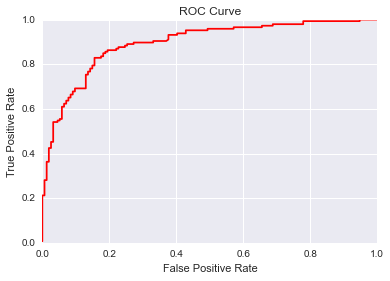

In [91]:
# Import seaborn
import seaborn as sns
from seaborn import plt
%matplotlib inline

# Plot our ROC Curve
fig, ax = plt.subplots(1,1)
ax.plot(fpr, tpr, label='ROC Curve', color='red')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC Curve')

##Exercise - Spam Classification

We'll step through a similar exercise with the spam classification dataset [here](https://github.com/pburkard88/DS_BOS_06/Data/Spam Classification/sms.csv) (note that this is a pre-parsed version of the one from the UCI website, so make sure to use this one).  The goal is to be able to classify raw text SMS messages as either spam or not spam based on the training set given.  We'll again use a Naive Bayes Multinomial model to do so.

First import `numpy` and `pandas`

In [92]:
# Importing numpy and pandas 
import numpy as np
import pandas as pd

Now read in the data with `pandas` `read_csv()` and check it out with `head()`:

In [94]:
## READING IN THE DATA
df = pd.read_csv("/Users/pburkard88/git/GA/Data Science/DAT_SF_14/labs/data/sms.csv")
# Check it out with head()
df.head(10)

,label,msg
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
5,spam,FreeMsg Hey there darling it's been 3 week's n...
6,ham,Even my brother is not like to speak with me. ...
7,ham,As per your request 'Melle Melle (Oru Minnamin...
8,spam,WINNER!! As a valued network customer you have...
9,spam,Had your mobile 11 months or more? U R entitle...


How many records are they of each type (spam/not spam)?

In [2]:
# Check out value_counts
df.label.value_counts()

NameError: name 'df' is not defined

We want our *label* column to be binary, so use map to convert that column to 0 for 'ham' and 1 for 'spam'.

In [95]:
# Convert the label into a binary variable with map
df['label'] = df.label.map({'ham': 0 , 'spam':1})
# Use head() to make sure it worked
df.head()

,label,msg
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


Generate a **70/30 train/test split** with [`sklearn.cross_validation.train_test_split()`](http://scikit-learn.org/stable/modules/generated/sklearn.cross_validation.train_test_split.html) and put the results in `X_train`, `X_test`, `y_train`, and `y_test`.  Give the call to your function the parameter `random_state=1`.

In [96]:
# split into training and testing sets by calling sklearn lib
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df.msg, df.label, random_state=1)

Print out some of `X_train` as well as the shape of `X_train` and `X_test` using `shape`.

In [97]:
# Print the shape of X_train
print X_train.shape
# Print X_train
print X_train

(4179,)
710     4mths half price Orange line rental & latest c...
3740                           Did you stitch his trouser
2711    Hope you enjoyed your new content. text stop t...
3155    Not heard from U4 a while. Call 4 rude chat pr...
3748    �� neva tell me how i noe... I'm not at home i...
2389    wiskey Brandy Rum Gin Beer Vodka Scotch Shampa...
3464    i am seeking a lady in the street and a freak ...
772     Lol! U drunkard! Just doing my hair at d momen...
3667    I'm turning off my phone. My moms telling ever...
4955    U coming back 4 dinner rite? Dad ask me so i r...
854     AH POOR BABY!HOPE URFEELING BETTERSN LUV! PROB...
4079                  Gam gone after outstanding innings.
2837                         Nice.nice.how is it working?
1392                  Haha just kidding, papa needs drugs
5533    Hey chief, can you give me a bell when you get...
874     Ugh its been a long day. I'm exhausted. Just w...
4408    Awesome, plan to get here any time after like ...
3990  

In [98]:
# Print the shape of X_test
X_test.shape

(1393,)

###Generating Features
Use `sklearn.feature_extraction.text.CountVectorizer` on the training set to create a vectorizer called `vect`.

In [ ]:
# Import CountVectorizer
from sklearn.feature_extraction.text import CountVectorizer
# instantiate the vectorizer ( use variable name as vect)
vect = CountVectorizer(decode_error = 'ignore')
# Fit the vectorizer to the training set X_train
vect.fit(X_train)
# Print out the dictionary of terms with get_feature_names()
vect.get_feature_names()

Now that we have a vectorizer trained on `X_train`, call `transform()` on both `X_train` and `X_test` to get the **Document Term Matrix** for each.  Store your results into `train_dtm` and `test_dtm`.

In [99]:
# Generate train_dtm
train_dtm = vect.transform(X_train)
# Generate test_dtm
test_dtm = vect.transform(X_test)

Take a look at the first 50 and last 50 features of your dataset by investigating `vect.get_feature_names()`.  ***HINT:*** It's just a `list`.

In [100]:
# First 50
print vect.get_feature_names()[:50]
# Last 50
print vect.get_feature_names()[-50:]

[u'10', u'11', u'12', u'13', u'15', u'20', u'2005', u'2160', u'24', u'2mp', u'325', u'3o', u'42', u'44', u'4s', u'50', u'5020', u'510', u'5320', u'680', u'700w', u'8125', u'abhor', u'able', u'abound', u'about', u'above', u'absolutel', u'absolutely', u'ac', u'accept', u'acceptable', u'access', u'accessing', u'accidentally', u'accompanied', u'according', u'activate', u'activated', u'actually', u'ad', u'adapter', u'adapters', u'addition', u'additional', u'adhesive', u'adorable', u'advertised', u'advise', u'after']
[u'white', u'who', u'whole', u'whose', u'wi', u'wife', u'wild', u'will', u'wind', u'window', u'winner', u'wiping', u'wire', u'wired', u'wireless', u'wise', u'wish', u'with', u'within', u'without', u'wobbly', u'won', u'wonder', u'wonderfully', u'wood', u'word', u'work', u'worked', u'working', u'works', u'world', u'worn', u'worst', u'worth', u'worthless', u'worthwhile', u'would', u'wouldn', u'wow', u'wrong', u'wrongly', u'year', u'years', u'yell', u'yes', u'yet', u'you', u'your', 

###Build the Model
Use `sklearn` to build a `MultinomialNB` classifier against your training data.

In [101]:
# Import MultinomialNB
from sklearn.naive_bayes import MultinomialNB
# Create model
nb = MultinomialNB()
# Fit model
nb.fit(train_dtm, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

###Evaluate the Model
Use `sklearn.metrics` to retrieve the following evaluation metrics for your model against the test set:
- Percent Accuracy
- Precision
- Recall
- F1
- Confusion Matrix
- ROC: Plot the curve and return the area under the curve
- A classification report via a simple call to `classification_report`

In [102]:
# Import metrics
from sklearn import metrics

In [104]:
# Generate predictions for test_dtm, call them y_pred
y_pred = nb.predict(test_dtm)

In [105]:
# Percent Accuracy
print metrics.accuracy_score(y_test, y_pred)

0.965541995693


In [106]:
# Precision
print metrics.precision_score(y_test, y_pred)

0.895953757225


In [107]:
# Recall
print metrics.recall_score(y_test, y_pred)

0.837837837838


In [108]:
# F1
print metrics.f1_score(y_test, y_pred)

0.865921787709


In [110]:
# Confusion matrix
print metrics.confusion_matrix(y_test, y_pred)

[[1190   18]
 [  30  155]]


0.976293180598


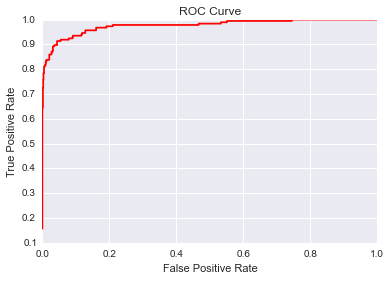

In [115]:
# ROC Curve Area
print metrics.roc_auc_score(y_test, nb.predict_proba(test_dtm)[:, 1])
# ROC Curve
fpr, tpr, thresholds = metrics.roc_curve(y_test, nb.predict_proba(test_dtm)[:, 1])
fig, ax = plt.subplots(1,1)
ax.plot(fpr, tpr, color='red')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC Curve')

In [118]:
# Classification Report
print metrics.classification_report(y_test, y_pred)

             precision    recall  f1-score   support

          0       0.98      0.99      0.98      1208
          1       0.90      0.84      0.87       185

avg / total       0.96      0.97      0.97      1393



###Extra: Playing with pandas
Use the arrays train_dtm and test_dtm along with y_train and y_test to see if you can put the data back into dataframes called `df_train` and `df_test`, where the columns are the feature names.
- Get the feature names with `get_feature_names()`
- Pass the `numpy` array data explicitly to the `pandas.DataFrame` constructor along with the column names from `get_feature_names()`

In [123]:
df_train = pd.DataFrame(train_dtm.toarray(), columns=vect.get_feature_names())
df_train['target']=y_train
df_train.head()

,10,11,12,13,15,20,2005,2160,24,2mp,...,year,years,yell,yes,yet,you,your,z500a,zero,target
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,1,0,0,1
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,NaN
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,NaN


Check out which words are most indicative of spam vs. not spam, which words appear the most in the dataset, and which words the least.